# 导入包

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import six
import os
import random
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision import transforms as tfs
from torchnet.meter import ConfusionMeter, AverageValueMeter
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdmw
import hiddenlayer as hl
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFile
import xml.etree.ElementTree as ET
from skimage import transform as sktfs
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cupy as cp
import pdb
# %pdb on
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
"""
#TODO
为了解决以下问题
received 0 items of ancdata
将限制提高到很高，超过了我的数据集大小
"""
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (204800, rlimit[1]))

# 神经网络训练与推理配置

In [2]:
class Config:
    # voc data config
    voc_data_dir = "../data/VOCdevkit/VOC2012/"
    voc_annotation_dir = os.path.join(voc_data_dir, 'Annotations')
    voc_train_test_ratio = 0.7
    voc_train_anno_xml = []
    voc_test_anno_xml = []
    resize_img_min_size = 600
    resize_img_max_size = 1000
    train_data_load_num_workers = 32
    test_data_load_num_workers = 16
    # L1 Smooth Loss
    rpn_sigma = 3
    roi_sigma = 1
    # optimizer
    weight_decay = 5e-4
    lr = 1e-3
    lr_decay = 0.1
    lr_decay_step=1e4
    # hiddenlayer config
    plot_batch=50
    train_history_path = "./train_history,pkl"
    # training
    epoch = 14
    use_adam = False
    use_drop = False
    test_num = 1e4
    #save and load FasterRCNN model
    save_path="/mnt/azDoc/FasterRCNNGPU"
    FasterRCNN_model_path = "./FasterRCNN_model_test.pth"

    def __init__(self):
        anno_xml_list = os.listdir(Config.voc_annotation_dir)
        voc_data_nums = len(anno_xml_list)
        print(voc_data_nums)
        all_index = np.arange(0, voc_data_nums, 1, dtype=np.int32)
        train_index = random.sample(
            all_index.tolist(), int(voc_data_nums * Config.voc_train_test_ratio))
        test_index=np.delete(all_index,train_index)
        Config.voc_train_anno_xml=[anno_xml_list[i] for i in train_index]
        Config.voc_test_anno_xml=[anno_xml_list[i] for i in test_index]


opt = Config()
print(type(opt.voc_test_anno_xml),type(opt.voc_train_anno_xml))
print(len(opt.voc_test_anno_xml),len(opt.voc_train_anno_xml))

17125
<class 'list'> <class 'list'>
5138 11987


# 数据集准备工作

## 建议框处理

In [3]:
def resize_bbox(bbox, in_size, out_size):
    """
    Args:
        bbox (~numpy.ndarray):(R,4)
        in_size(tuple):图像 resize 之前的长宽
        out_size(tuple):图像 resize 之后的长宽
    """
    #TODO 去掉所有的copy看内存占用会不会稳定下来
    bbox=bbox-np.zeros_like(bbox)
#     bbox = bbox.copy()
    y_scale = float(out_size[0] / in_size[0])
    x_scale = float(out_size[1] / in_size[1])
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]

    return bbox


def flip_bbox(bbox, size, y_flip=False, x_flip=False):
    """
    根据 y_flip,x_flip 进行翻转
    Args:
        bbox (~numpy.ndarray):{ymin,xmin,ymax,xmax}
        size(tuple)：图像 resize 之后的（高，宽）
    """
    H, W = size
    #TODO 去掉所有的copy看内存占用会不会稳定下来
    bbox=bbox-np.zeros_like(bbox)
#     bbox = bbox.copy()
    if y_flip:
        y_max = H - bbox[:, 0]
        y_min = H - bbox[:, 2]
        bbox[:, 0] = y_min
        bbox[:, 2] = y_max
    if x_flip:
        x_max = W - bbox[:, 1]
        x_min = W - bbox[:, 3]
        bbox[:, 1] = x_min
        bbox[:, 3] = x_max

    return bbox


def random_flip_img(img,
                    y_random=False,
                    x_random=False,
                    return_para=False,
                    copy=False):
    """
    随机翻转
    Args:
        img (~numpy.ndarray):CHW 格式
        y_random: H 维翻转
        x_random: W 维翻转
        copy: 决定是否返回 img copy副本，这样可以割裂开两者的关系使得 img 还能继续使用
    Returns:
        翻转后的 img ，根据输入参数觉得是否返回翻转参数
    """
    y_flip, x_flip = False, False
    if y_random:
        y_flip = random.choice([True, False])
    if x_random:
        x_flip = random.choice([True, False])

    if y_flip:
        img = img[:, ::-1, :]
    if x_flip:
        img = img[:, :, ::-1]
    if copy:
        img = img.copy()
    #TODO 尝试解决负索引问题
    img = img-np.zeros_like(img)
    if return_para:
        return img, {'y_flip': y_flip, 'x_flip': x_flip}
    else:
        return img

## 数据集预处理(Transform)

In [4]:
def normalize_img(img):
    normalize = tfs.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(torch.from_numpy(img))
    return img.numpy()


def preprocess(img, min_size=600, max_size=1000):
    """
    缩放图像，令图像的长边不超过 max_size，短边不超过 min_size 
    然后进行归一化
    返回 numpy 类型
    """
    C, H, W = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale3 = min(scale1, scale2)
    img = img / 255.
    # 源码是下边带 anti_aliasing=False 的，可能是 skimage 的版本不一样，0.14 有这一项，0.13 没有
    img = sktfs.resize(img, (C, H * scale3, W * scale3), mode="reflect")
    #     img = sktfs.resize(
    #         img, (C, H * scale3, W * scale3), mode="reflect", anti_aliasing=False)
    return normalize_img(img)


class Transform(object):
    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, o_H, o_W = img.shape  # img resize 之前
        img = preprocess(img, self.min_size, self.max_size)
        _, p_H, p_W = img.shape  # img resize 之后
        scale = p_H / o_H  #得到图像 的缩放比例
        bbox = resize_bbox(bbox, (o_H, o_W), (p_H, p_W))

        # 随机翻转图像与 bbox
        img, params = random_flip_img(
            img, y_random=False, x_random=True, return_para=True)
        bbox = flip_bbox(bbox, (p_H, p_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

## 数据集读取

In [5]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane',  #0
    'bicycle',  #1
    'bird',  #2
    'boat',  #3
    'bottle',  #4
    'bus',  #5
    'car',  #6
    'cat',  #7
    'chair',  #8
    'cow',  #9
    'diningtable',  #10
    'dog',  #11
    'horse',  #12
    'motorbike',  #13
    'person',  #14
    'pottedplant',  #15
    'sheep',  #16
    'sofa',  #17
    'train',  #18
    'tvmonitor'  #19
)


class VOCDataset:
    """
    
    """

    def __init__(self,
                 opt,
                 anno_xml_list,
                 use_difficult=False,
                 return_difficult=False):
        self.annotation_dir = os.path.join(opt.voc_data_dir, 'Annotations')
        self.images_dir = os.path.join(opt.voc_data_dir, 'JPEGImages')
        print("图片数量：", len(os.listdir(self.images_dir)))
        print("XML数量：", len(os.listdir(self.annotation_dir)))
        self.anno_xml_list = anno_xml_list
        self.len_xml = len(self.anno_xml_list)
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult

    def get_example(self, index):
        """
        Returns:
            img:(C,H,W)
            bbox:(R,4)
            label:(R,)
            difficult:(R,)
        """
        bbox = []
        label = []
        difficult = []
        x = self.anno_xml_list[index]
        x_dir = os.path.join(self.annotation_dir, x)
        _id, _ = x.split('.')
        img_dir = os.path.join(self.images_dir, str(_id) + '.jpg')
        anno = ET.parse(x_dir)
        for obj in anno.findall('object'):
            # 如果是困难的就忽略吧，没必要为难自己
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue
            difficult.append(int(obj.find('difficult').text))
            bnb = obj.find('bndbox')
            bbox.append([
                int(float(bnb.find(tag).text)) - 1 
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')
            ])
            name = obj.find('name').text.lower().strip()  #小写，去除头尾空格
            label.append(VOC_BBOX_LABEL_NAMES.index(name))

        difficult = np.array(
            difficult, dtype=np.bool).astype(np.uint8)  #pytorch 不支持 np.bool
        try:
            bbox = np.stack(bbox).astype(np.float32)
            label = np.stack(label).astype(np.int32)
        except:
            img, bbox, label, difficult = self.get_example(np.random.randint(0,self.len_xml))
            #             print(x_dir)
            return img, bbox, label, difficult

        img = np.array(Image.open(img_dir), dtype=np.float32)
        # Image.open |-->W,H
        # np.asarray(Image) |-->H,W,C
        # tfs.ToTensor() |-->Converts a PIL Image or numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
        #DONE 这句话有待考证，这个换维有点奇怪，不知道是不是以前的代码的问题，先留着咯
        # 后边会直接将这张图片归一化，直接以CHW形式怼进网络里边，其实 ToTensor 这个函数也就是这么个操作法
        img = img.transpose(2, 0, 1)  # |-->C,H,W

        return img, bbox, label, difficult

    # 为了后续方便用 get_example 这个函数而又不破坏私有关系
    __getitem__ = get_example

    def __len__(self):
        return self.len_xml

## 训练与测试数据集

In [6]:
class TrainDataset:
    def __init__(self, opt):
        self.opt = opt
        self.db = VOCDataset(self.opt, self.opt.voc_train_anno_xml)
        self.tfs = Transform(self.opt.resize_img_min_size,
                             self.opt.resize_img_max_size)

    def __getitem__(self, index):
        ori_img, bbox, label, difficult = self.db.get_example(index)
        #TODO 测试输入输出图像，完成后可以删了
        #         print("之前",np.mean(ori_img))
        #         plt.figure(0)
        #         plt.imshow(ori_img.transpose(1,2,0).astype(np.int32))
        img, bbox, label, scale = self.tfs((ori_img, bbox, label))
        #TODO: check whose stride is negative to fix this instead copy all
        # some of the strides of a given numpy array are negative.
#         return img.copy(), bbox.copy(), label.copy(), scale
        return img, bbox, label, scale#有错误

    def __len__(self):
        return len(self.db)


class TestDataset_acc:
    def __init__(self, opt):
        self.opt = opt
        self.db = VOCDataset(self.opt, self.opt.voc_train_anno_xml)
        self.tfs = Transform(self.opt.resize_img_min_size,
                             self.opt.resize_img_max_size)

    def __getitem__(self, index):
        ori_img, bbox, label, difficult = self.db.get_example(index)
        scale = 1.0
        return ori_img.copy(), bbox.copy(), label.copy(), scale

    def __len__(self):
        return len(self.db)


class TestDataset:
    def __init__(self, opt, use_difficult=True):
        self.opt = opt
        self.db = VOCDataset(
            self.opt, self.opt.voc_test_anno_xml, use_difficult=use_difficult)

    def __getitem__(self, index):
        ori_img, bbox, label, difficult = self.db.get_example(index)
        img = preprocess(ori_img)
        return img, ori_img.shape[1:], bbox, label, difficult

    def __len__(self):
        return len(self.db)

# 初始化创建～2w个建议框

In [7]:
def create_anchor_base(base_size=16,
                       ratios=[0.5, 1, 2],
                       anchor_scales=[8, 16, 32]):
    '''
    经过了4层池化层，原图边长总共缩小了 base_size=16 倍
    anchor的长宽比例为 ratios=[0.5, 1, 2]
    每个anchor的边长为 anchor_scales=[8, 16, 32]*base_size
    Return:
        anchor_base:(y_{min}, x_{min}, y_{max}, x_{max})
    '''
    py = base_size / 2.
    px = base_size / 2.
    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4),
                           dtype=np.float32)
#     for i in range(len(ratios)):
#         for j in range(len(anchor_scales)):
    #TODO 换用six，试试看
    for i in six.moves.range(len(ratios)):
        for j in six.moves.range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * 1. / np.sqrt(ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2
            anchor_base[index, 1] = px - w / 2
            anchor_base[index, 2] = py + h / 2
            anchor_base[index, 3] = px + w / 2
    return anchor_base


def shift_anchor(anchor_base, feature_stride, ht, wd):
    """
    将 anchor_base 按照一定步长平移得到覆盖全图的 anchor 
    feature_stride 池化步长 prod
    ht，wd 最后特征图的长宽
    """
    shifty = np.arange(0, ht * feature_stride, feature_stride)
    shiftx = np.arange(0, wd * feature_stride, feature_stride)
    shiftx, shifty = np.meshgrid(shiftx, shifty)
    shift = np.stack(
        (shifty.ravel(), shiftx.ravel(), shifty.ravel(), shiftx.ravel()),
        axis=1)
    A = anchor_base.shape[0]
    K = shift.shape[0]
    # numpy 的特殊加法
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape(
        (1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


# ab = create_anchor_base()
# print(ab.shape)
# sa = shift_anchor(ab, 16, 18, 32)
# print(sa.shape)

# 特征提取与建议框提取
    使用 ResNet34 来提取特征
    流经 RPN （Region Proposal Network）进行前景判别与回归
    经过 ProposalCreator 来缩小范围
    

## Resnet34
提取投特征

In [8]:
device = torch.device("cuda")
#TODO 更换成resnet50
# prenet = torchvision.models.resnet34(pretrained=True)
# del prenet.maxpool
prenet = torchvision.models.vgg16_bn(pretrained=True)  #[:43]
del prenet.classifier[6]


class feature34(nn.Module):
    """
    使用 resnet34 作预训练的模型，来提取图片特征
    也使图片长宽缩小16倍到最后的特征图
    """

    def __init__(self):
        super(feature34, self).__init__()
        #         self.features = nn.Sequential(*list(prenet.children())[:-3])
        self.features = nn.Sequential(*(list(prenet.features)[:43]))
        #         for layer in features:
        #             for p in layer.parameters():
        #                 p.requires_grad=False
        self.classifier=prenet.classifier
        self.outchannels = 512

    def forward(self, x):
        out = self.features(x)
        return out


# img = Image.open("./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg")
# im = tfs.ToTensor()(img)
# im = im.unsqueeze(0)
# im = feature34()(im)
# print(im.shape)

## NMS GPU

In [9]:
import nms
def NMS_gpu(*args,**kwargs):
    return nms.non_maximum_suppression(*args,**kwargs)

## ProposalCreator
利用 NMS 非极大值抑制去掉大部分重叠的框

In [10]:
def loc2bbox(src_bbox, loc):
    """
    Args:
        src_bbox(array):array(?,4)
        loc(array):array(?,4)
    将源 BBOX 经过 loc 的信息转换成新的BBOX
    """
    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)
    src_ht = src_bbox[:, 2] - src_bbox[:, 0]
    src_wd = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_ht
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_wd

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_ht[:,np.newaxis] + src_ctr_y[:,np.newaxis]
    ctr_x = dx * src_wd[:,np.newaxis] + src_ctr_x[:,np.newaxis]
    h = np.exp(dh) * src_ht[:,np.newaxis]
    w = np.exp(dw) * src_wd[:,np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox_iou(bbox_a, bbox_b):
    """
    Args:
        bbox_a(array):array(N,4)
        bbox_b(array):array(K,4)
    Returns:
        array(N,K)
        即计算 a 与 b 两两之间的IOU
    """
    #     print("a", bbox_a.shape, "b", bbox_b.shape)
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError

    # 使用 numpy 的广播进行快捷计算
    top_left = np.maximum(bbox_a[:, np.newaxis, :2], bbox_b[:, :2])
    bottom_right = np.minimum(bbox_a[:, np.newaxis, 2:], bbox_b[:, 2:])
    # 若存在 top_left > bottom_right 的，则说明两者不相交，IOU 为零
    area_i = np.prod(bottom_right-top_left, axis=2) * \
        (top_left < bottom_right).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)

    return area_i / (area_a[:, np.newaxis] + area_b - area_i)


def NMS_cpu(bboxs, score, thresh, keep_nums=None):
    """
    #TODO 可以改造成C语言甚至GPU版本，速度可以加快上百倍
    Args:
        bboxs(array):array(N,4)
        score
    """
    order = score.reshape(-1).argsort()[::-1]
    if keep_nums is not None :
        if keep_nums > 0 and order.size > keep_nums:
            order = order[:keep_nums].reshape(-1)
    else:
        order = order.reshape(-1)

    keep = list()
    while order.size > 0:
        i = order[0]
        keep.append(i)  # 保留最大的一个

        iou = bbox_iou(bboxs[i, np.newaxis, :],
                       bboxs[order[1:], :])  # 计算最大的与剩下的IOU
        #         print(iou.shape)
        index = np.where(iou.reshape(-1) <= thresh)[0]  # 选择 IOU 小于阈值的框
        #         print(index)
        order = order[index + 1]  # where 返回的思从零开始，而order从一开始
    return keep


class ProposalCreator(object):
    """
    输入展平后的 loc 和 score ，
    使用 loc 的信息对每一个（2w+）建议框进行微调
    然后裁剪过大的框到被原图包含，去掉过小的框（h,w<16）
    最后使用 score 的信息对剩下来的框进行 NMS （非极大值抑制）
    """

    def __init__(self,
                 parent_model,
                 nms_thresh=0.7,
                 n_train_pre_nms=12000,
                 n_train_post_nms=2000,
                 n_test_pre_nms=6000,
                 n_test_post_nms=300,
                 min_size=16):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score, anchors, img_size, scale=1.0):
        """
        Args:
            loc:
            score:
            anchors:array(?,4)，初始化然后经过微调的 2w+ 个框
        """
        if self.parent_model.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # 使用 loc 的信息微调建议框
        roi = loc2bbox(anchors, loc)
        # 裁剪框
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0,
                                         img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0,
                                         img_size[1])
        # 去掉过小的框
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # 使用 NMS 非极大值抑制，进一步减少框数量
#         keep = NMS_cpu(roi, score, self.nms_thresh, n_pre_nms)
        # 使用 GPU 版本 nms 来算
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]
        keep=NMS_gpu(cp.ascontiguousarray(cp.array(roi)),thresh=self.nms_thresh)
        
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi

## RegionProposalNetwork
前景判断与回归 

（要考虑当前景为零的情况）

In [11]:
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(
            mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


class RegionProposalNetwork(nn.Module):
    def __init__(self,
                 in_channels=512,
                 mid_channels=512,
                 feature_stride=16,
                 #TODO 这个base_size可以扔了
#                  base_size=16,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32],
                 proposal_creator_args=dict()):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = create_anchor_base(
            base_size=feature_stride,
            ratios=ratios,
            anchor_scales=anchor_scales)
        n_anchor = self.anchor_base.shape[0]  # 基础的 9 个 anchors
        self.proposalcreator = ProposalCreator(self)#, **proposal_creator_args)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        # 1x1 的卷积相当于无偏置的线性加法
        # 由此产生一组 n_anchor*4 的 hh×ww 的特征图
        # 也就可以用这些信息对应地去微调初始化得到的 2w+ 个框
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.loc, 0, 0.01)
        normal_init(self.score, 0, 0.01)

    def forward(self, x, img_size, scale=1.0):
        n, _, hh, ww = x.shape
        shifted_anchors = shift_anchor(self.anchor_base, feature_stride, hh,
                                       ww)

        n_anchor = shifted_anchors.shape[0] // (hh * ww)

        h = F.relu(self.conv1(x))
        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        # 利用 softmax 转换成概率形式
        rpn_softmax_scores = F.softmax(
            rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        # 然后仅仅提取前景（即分类为1）的概率出来当做评价分数
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        # rpn_scores 则作后续 Loss 用途
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposalcreator(
                rpn_locs[i, :, :].cpu().data.numpy(),
                rpn_fg_scores[i, :].cpu().data.numpy(),
                shifted_anchors,
                img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi), ), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)
        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)

        return rpn_locs, rpn_scores, rois, roi_indices, shifted_anchors

# 训练阶段需要的框Creator

## Anchor Target Creator
产生训练 RPN 所需的框


In [12]:
def get_inside_index(anchor, H, W):
    """
    获取四角都在图内的anchor的索引
    """
    index_inside = np.where((anchor[:, 0] >= 0) & (anchor[:, 1] >= 0) &
                            (anchor[:, 2] <= H) & (anchor[:, 3] <= W))[0]
    return index_inside


def bbox2loc(src_bbox, dst_bbox):
    """
    将四角形式的 bbox 重新转换成中心宽高的 loc
    Args:
        src_bbox:原 bbox
        dst_bbox: src_bbox 经过 loc 微调后的的 bbox 
    """
    src_ht = src_bbox[:, 2] - src_bbox[:, 0]
    src_wd = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_ht
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_wd

    dst_ht = dst_bbox[:, 2] - dst_bbox[:, 0]
    dst_wd = dst_bbox[:, 3] - dst_bbox[:, 1]
    dst_ctr_y = dst_bbox[:, 0] + 0.5 * dst_ht
    dst_ctr_x = dst_bbox[:, 1] + 0.5 * dst_wd

    eps = np.finfo(src_ht.dtype).eps
    src_ht = np.maximum(eps, src_ht)
    src_wd = np.maximum(eps, src_wd)

    dy = (dst_ctr_y - src_ctr_y) / src_ht
    dx = (dst_ctr_x - src_ctr_x) / src_wd
    dh = np.log(dst_ht / src_ht)
    dw = np.log(dst_wd / src_wd)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc


def _unmap(data, count, index, fill=0):
    """
    将选出来的子集的数据反向嵌入回原集里
    """
    if len(data.shape) == 1:
        ret = np.empty((count, ), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count, ) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret


class AnchorTargetCreator(object):
    """
    为初始化生成的 2w+ 个框附加上 gt 标签
    """

    def __init__(self,
                 n_sample=256,
                 pos_iou_thresh=0.7,
                 neg_iou_thresh=0.3,
                 pos_ratio=0.5):
        """
        n_sample:采样个数
        pos_iou_thresh：前景 iou 阈值
        neg_iou_threash：背景 iou 阈值
        pos_ratio：前景比例
        """
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, gt_bbox, shifted_anchors, img_size):
        """
        Args:
            gt_bbox:array(R,4) 
            shifted_anchors:array(S,4) S=2w+
            img_size:..
        """
        img_ht, img_wd = img_size
        n_anchor = len(shifted_anchors)
        # 限制在图像内
        inside_index = get_inside_index(shifted_anchors, img_ht, img_wd)
        inside_anchor = shifted_anchors[inside_index]
        # 
        argmax_ious, label = self._create_label(inside_index, inside_anchor,
                                                gt_bbox)
        # inside_anchor 与其目标 gt_bbox 反向微调的 loc 
        loc = bbox2loc(inside_anchor, gt_bbox[argmax_ious])
        # 将 label loc 反向嵌套回原集合
        label = _unmap(label, n_anchor, inside_index,fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)
        return loc, label

    def _create_label(self, inside_index, shifted_anchors, bbox):
        """
        根据 iou 与阈值，生成 label 
        正样本 1 ，负样本 0 ，忽略样本 -1 .
        Return：
            argmax_ious:每个 anchor 与哪个 gt_bbox 最接近，即 iou 最大
            label:每个 anchor 的标签
        """
        label = -np.ones((len(inside_index), ), dtype=np.int32)
        argmax_ious, max_ious, gt_argmax_ious = self._cal_ious(
            shifted_anchors, bbox, inside_index)
        # 令负样本的 label 为 0
        label[max_ious < self.neg_iou_thresh] = 0
        # 令正样本的 label 为 1
        # 最高 iou 的肯定先设置为 1 
        #Question 正样本应该够多了，何必再来这一步呢？
        #Answer 其实不够的～
        label[gt_argmax_ious] = 1
        # 然后是大于阈值的 iou ,？然而这一步不一定有足够的，所以就需要上边那一步了？
        label[max_ious > self.pos_iou_thresh] = 1

        # 然而没有这么简单，正样本可能比较多，太多了
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(
                pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1
        # 负样本也是，多得消化不良
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(
                neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label

    def _cal_ious(self, anchor, bbox, inside_index):
        """
        输入的 anchor 已经是 inside 之后的 anchor 
        计算 anchors 和 gt bboxs 之间的 iou 
        """
        # 计算之间的 iou
        ious = bbox_iou(anchor, bbox)
        # 对比第 1 维，看 anchor 与哪个 bbox 的 iou 最高
        argmax_ious = ious.argmax(axis=1)
        # 选出 iou 最高的值
        #TODO len(inside_index) 其实可以改成 ious.shape[0]
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        # 选出 gt_bbox 最大 iou 的 anchor
        gt_argmax_ious = ious.argmax(axis=0)
        # 选出 iou 最高的值
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        # 与前两行似有重复，实质 iou 可能有相等的，此举为提取全部可能的 iou
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]
        return argmax_ious, max_ious, gt_argmax_ious

## Proposal Target Creator

In [13]:
class ProposalTargetCreator(object):
    """
    进一步【筛选】 ProposalCreator 【筛选】出来的框，并为之赋予标签
    """

    def __init__(self,
                 n_sample=128,
                 pos_ratio=0.25,
                 pos_iou_thresh=0.5,
                 neg_iou_thresh_hl=0.5,#TODO 得空把他改回 neg_iou_thresh_hi  
                 neg_iou_thresh_lo=0.0,#TODO py-faster-rcnn 中默认是 0.1 
                ):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_hl = neg_iou_thresh_hl
        self.neg_iou_thresh_lo = neg_iou_thresh_lo

    def __call__(self,
                 roi,
                 gt_bbox,
                 label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        """
        Args:
            roi(array):array(R,4) ProposalCreator 筛选出来的框
            gt_bbox(array):array(R‘,4) 真实的框
            label(array):array(R’,) 真实的框标签
            loc_normalize_mean:
            loc_normalize_std
        #TODO 此 Creator 后续可能会增加对多张图（多 batch ）的支持，输入可能需要多一项 roi_indcies
        """
        n_bbox, _ = gt_bbox.shape
        # 将预选框与真实框堆在一起
        #TODO 但感觉上并不需要，顶多是肯定的为训练提供了R‘个精准框而已
        roi = np.concatenate((roi, gt_bbox), axis=0)

        iou = bbox_iou(roi, gt_bbox)
        # 找出 roi 与哪个 gt_bbox 有最大的 iou，将其当做这个 roi 的回归目标框与标签
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)

        # 将前景 foreground 标签从 [0,n_fg_class-1] 转换到 [1,n_fg_class]
        # 背景 background 的标签设置为 0
        # 注意，label[...] 会根据 [gt_assignment] 进行扩充。。
        #e.g.# a=np.array([1,2,3,4,5]);print(a);b=a[[3,4,2,2,2,2,2,2,]];print(b)
        gt_roi_label = label[gt_assignment] + 1
        
        # 选出 iou 大于阈值的作正样本
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        # 筛选过多的正样本
        pos_roi_per_img = np.round(self.n_sample * self.pos_ratio)
        pos_roi_per_img_should_be = int(min(pos_roi_per_img, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(
                pos_index, size=pos_roi_per_img_should_be, replace=False)

        # 选负样本
        neg_index = np.where((max_iou < self.neg_iou_thresh_hl) &
                             (max_iou > self.neg_iou_thresh_lo))[0]
        neg_roi_per_img = self.n_sample - pos_roi_per_img_should_be
        neg_roi_per_img_should_be = int(min(neg_roi_per_img, neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(
                neg_index, size=neg_roi_per_img_should_be, replace=False)

        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        # 设置正样本之后的负样本的标签为 0，也就是背景
        gt_roi_label[pos_roi_per_img_should_be:] = 0
        sample_roi = roi[keep_index]
        #此处得到标签框与真实框的差值 loc 
        gt_roi_loc = bbox2loc(sample_roi, gt_bbox[gt_assignment[keep_index]])
        #DONE 归一化，维持住正态分布
        gt_roi_loc = (gt_roi_loc - np.array(loc_normalize_mean, np.float32)
                      ) / np.array(loc_normalize_std, np.float32)
        
        return sample_roi,gt_roi_loc,gt_roi_label

# ROI Pooling
裁剪 roi 到特征图，无论前边多大，一律裁剪到 7x7

有四种方法，但一个比一个慢.
1. 用 cffi 来进行C扩展然后pytorch调用
2. 利用Cupy在线编译，直接为pytorch提供cuda扩展
3. 利用chainer实现（完全python）
4. pytorch自带函数库
    * torch.nn.functional.adaptive_max_pool2d
    * torch.nn.AdaptiveMaxPool2d


## ROIPooling Cupy

In [14]:
from roi_modeule import RoIPooling2D as RoIPooling2D_Cupy


## ROIPooling Pytorch

In [15]:
class ROIPooling2D(nn.Module):
    """
    目前只实现一张图的训练，所以输入特征图 x 的 batch 为 1 
    裁剪 ROI 到特征图上的点位，然后实现 ROIPooling 
    Args:
        roipooing_size:ROIPooing 的大小
        saptial_size:从原图到特征图，经过的步长倒数（也就是1/16）
    """
    def __init__(self,roipooing_size,spatial_size):
        super(ROIPooling2D,self).__init__()
        if isinstance(roipooing_size,tuple):
            self.outh,self.outw=roipooing_size
        else:
            self.outh=roipooing_size
            self.outw=roipooing_size
        self.spatial_size=spatial_size
        #TODO 这句自适应pooling 可以利用C扩展，速度更上几个数量级
        self.roipooling=nn.AdaptiveMaxPool2d((self.outh,self.outw))
        
    def forward(self,x,rois,roi_indices):
        """
        #TODO 仅支持一张图，所以暂未用到参数 roi_indices 
        #后续可能会增加多张支持
        输入：特征图，ProposalCreator 输出的 ROIs 
        Args:
            x:array(n,c,h,w) 四维特征图
            rois:array(R,4) bbox四角坐标
            roi_indices:array(R,4) 每个框属于哪一张图
        输出：ROIPooing 后的固定大小的特征图
        """
        # ROIPooling 
        # 四舍五入取整，转换成特征图四角坐标
        n,_,_,_=x.shape
        if n!=1:
            print("对唔住，撑唔到两张图以上")
        rois=np.round(rois*self.spatial_size)
#         print("rois shape",rois.shape)# (128,4)
        rois_feature=None
        for roi in rois:
            #以下是确保roi最小有一个点
            y_ft_min=int(roi[0])
            y_ft_max=int(roi[2])
            x_ft_min=int(roi[1])
            x_ft_max=int(roi[3])
            if y_ft_min==y_ft_max:
                y_ft_max=y_ft_max+1
            if x_ft_min==x_ft_max:
                x_ft_max=x_ft_max+1
            roi_x=x[:,:,y_ft_min:y_ft_max,x_ft_min:x_ft_max]
            roi_ft=self.roipooling(roi_x)
            if rois_feature is None:
                rois_feature=roi_ft
                continue
            rois_feature=torch.cat([rois_feature,roi_ft],dim=0)
        return rois_feature

# ROI Head

In [16]:
class ROIHead(nn.Module):
    """
    Args:
        n_class:分类数目
        in_channels:输入通道数，
        roi_size：经过 ROIPooling 之后的特征图长宽
        spatial_size:池化步长倒数
    return:
        roi_cls_locs:array(R,4) roi 的中心长宽参数 loc 
        roi_scores:array(R,) roi 的分数
        
    """
    def __init__(self,n_class,in_channels,roi_size,spatial_scale):
        super(ROIHead,self).__init__()
        self.classifier=prenet.classifier
#         self.classifier=nn.Linear(roi_size*roi_size*in_channels,4096)
        self.cls_loc=nn.Linear(4096,n_class*4)
        self.score=nn.Linear(4096,n_class)
        normal_init(self.cls_loc,0,0.001)
        normal_init(self.score,0,0.01)
        
        self.n_class=n_class
        self.roi_size=roi_size
        self.spatial_scale=spatial_scale
        # 使用 ROIPooling Cupy 版
        self.roi=RoIPooling2D_Cupy(self.roi_size,self.roi_size,self.spatial_scale)
#         self.roi=ROIPooling2D(self.roi_size,self.spatial_scale)
        
    def forward(self,x,rois,roi_indices):
#         print("x",x.shape)#(1,256,x,x)
        # 使用 ROIPooling Cupy 版-------------
        roi_indices=totensor(roi_indices).float()
        rois=totensor(rois).float()
        indices_and_rois=torch.cat([roi_indices[:,np.newaxis],rois],dim=1)
        xy_indices_and_rois=indices_and_rois[:,[0,2,1,4,3]]
        indices_and_rois=xy_indices_and_rois.contiguous()
        pool=self.roi(x,indices_and_rois)
#         pool=self.roi(x,rois,roi_indices)
        #------------------------------------
#         print("pool.shape",pool.shape)#(128,256,7,7)
        # 此处 pool 在 view 之后，第0维是每个框的索引，第1维思每个框的特征了
        pool=pool.view(pool.size(0),-1)
        fc7=self.classifier(pool)
        roi_cls_locs=self.cls_loc(fc7)
        roi_scores=self.score(fc7)
        return roi_cls_locs,roi_scores

# FasterRCNN

In [17]:
feature_stride = 16


class FasterRCNNrensnet34(nn.Module):
    """
    构建整个网络
    """

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32],
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        super(FasterRCNNrensnet34, self).__init__()
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset("evaluate")
        self.extractor = feature34()
        self.rpn = RegionProposalNetwork(
            in_channels=self.extractor.outchannels,
            feature_stride=feature_stride,
            ratios=ratios,
            anchor_scales=anchor_scales,
        )
        self.head = ROIHead(
            n_fg_class + 1,
            self.extractor.outchannels,
            roi_size=7,
            spatial_scale=1. / feature_stride,
        )
        self.n_class = n_fg_class + 1

    def forward(self, x, scale=1.0):
        """
        Args:
            x:(B,C,H,W) 输入图像
        Returns:
            roi_cls_locs:(R,n_class*4) 最后Head输出的21类的微调建议
            roi_scores:(R,n_class) 最后Head输出的建议框的21类评分
            rois:(R,4) 由 RPN 输出的建议框
            roi_indices:(R,) 表示每个框归属于哪一张图片，此处仅有1张图，所以全都是0
        """
        img_size = x.shape[2:]
        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(
            h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        # 要输出最终结果，还需要一步 nms 筛选输出的 roi
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        """
        设置在预测时，或者评估时，使用的 NMS 阈值
        """
        if preset == "predict":
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        elif preset == "evaluate":
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError("预设必须是predict或者evaluate的其中一种")

    def suppress(self, raw_cls_bbox, raw_prob):
        """
        输入全是numpy
        """
        bbox = list()
        label = list()
        score = list()
        # 跳过索引0，这是背景类
        #TODO 检查前边那里是将其索引0做背景了
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            #使用NMS GPU 来算
            keep = NMS_gpu(cp.array(cls_bbox_l), self.nms_thresh, prob_l)
            keep = cp.asnumpy(keep)
            #             keep=NMS_cpu(cls_bbox_l,prob_l,self.nms_thresh)
            bbox.append(cls_bbox_l[keep])
            label.append((l - 1) * np.ones((len(keep), )))
            score.append(prob_l[keep])
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    def nograd(f):
        def new_f(*args, **kwargs):
            with torch.no_grad():
                return f(*args, **kwargs)

        return new_f

    #修饰器
    @nograd
    def predict(self, imgs, sizes=None, visualize=False):
        """
        对输入的图片数组进行目标检测
        Args:
            imgs:(np.ndarray) (N,C,H,W),N 为图片数量
                如果是 visualize 模式(visualize=True)，外部进来的img直接从PIL来转换成numpy并转换维度成CHW，
                    然后predict再对img做preprocess再输入网络
                如果是 evaluate 模式(visualize=False)，由于testdata已做preprocess，则无需再进行preprocess，
                    可以直接扔进网络了
                （sizes 就用得上了～
        Returns:
            bboxes:(np.ndarray)(N,R,4)
            labels:(np.ndarray)(N,R,)
            scores:(np.ndarray)(N,R,)
        """
        self.eval()
        if visualize:
            self.use_preset("predict")
            prepared_imgs = list()
            sizes = list()
            for img in imgs:
                size = img.shape[1:]  #(H,W)
                img = preprocess(tonumpy(img))
                prepared_imgs.append(img)
                sizes.append(size)
        else:
            prepared_imgs = imgs

        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            # 需要对(C,H,W)的img提升维度到(B,C,H,W),虽然 B=1
            img = totensor(img[np.newaxis]).float()
            scale = img.shape[3] / size[1]  # img_W / size_W = ori_img_W
            roi_cls_locs, roi_scores, rois, _ = self(img, scale=scale)
            roi_cls_loc = roi_cls_locs.data  #torch.Size([300, 84])
            roi_score = roi_scores.data
            roi = totensor(rois) / scale
            #TODO 检查之前除了proposaltargetcreator之外还有哪里对loc做了正态分布归一化
            # 去除 loc 的归一化
            mean = torch.tensor(self.loc_normalize_mean)\
                .cuda().repeat(self.n_class)[np.newaxis]#torch.Size([1, 84])
            std = torch.tensor(self.loc_normalize_std)\
                .cuda().repeat(self.n_class)[np.newaxis]
            #利用np的广播机制对 loc 扩增
            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            # 将roi(R,4) 扩成 (R,n_class,4) 如同 roi_cls_loc 形状
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(
                tonumpy(roi).reshape((-1, 4)),
                tonumpy(roi_cls_loc.reshape((-1, 4))))
            cls_bbox = totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2].clamp(min=0, max=size[0]))
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2].clamp(min=0, max=size[1]))

            #每个框将21类的评分通过 softmax 转化为概率
            # shape 还是一样，再来一个 max 就能挑出那个概率最大就是哪一类了
            prob = tonumpy(F.softmax(totensor(roi_score), dim=1))

            raw_cls_bbox = tonumpy(cls_bbox)
            raw_prob = tonumpy(prob)
            bbox, label, score = self.suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset("evaluate")
        self.train()
        return bboxes, labels, scores

# 训练阶段

## 训练器

In [18]:
def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()


def totensor(data, cuda=True):
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    elif isinstance(data, torch.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor


def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, torch.Tensor):
        return data.item()


LossTuple = namedtuple('LossTuple', [
    'rpn_loc_loss', 'rpn_cls_loss', 'roi_loc_loss', 'roi_cls_loss',
    'total_loss'
])


class FasterRCNNTrainer(nn.Module):
    """
    FasterRCNNrensnet34 只作为前向传播时候使用，也就是预测推理的时候
    FasterRCNNTrainer 则作为训练用，将 FasterRCNNrensnet34 作为输入网络
    """

    def __init__(self, faster_rcnn,opt):
        super(FasterRCNNTrainer, self).__init__()
        self.faster_rcnn = faster_rcnn
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()
        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std
        # 还有更好的方法，不同层使用不同的步长
        #         self.optimizer = torch.optim.Adam(self.faster_rcnn.parameters())
        self.optimizer = torch.optim.SGD(
            self.faster_rcnn.parameters(),
            lr=opt.lr,
            weight_decay=opt.weight_decay,
            momentum=0.9,
        )
        self.scheduler_lr = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=opt.lr_decay_step, gamma=opt.lr_decay)

        # torchnet 的混淆矩阵计算函数，里边是类别
        self.rpn_cm = ConfusionMeter(2)
        self.roi_cm = ConfusionMeter(21)
        self.loss_meters = {k: AverageValueMeter() for k in LossTuple._fields}

    def forward(self, imgs, bboxes, labels, scale):
        n = bboxes.shape[0]
        if n != 1:
            raise ValueError("就支持一张图，别搞多张的")
        _, _, H, W = img.shape
        img_size = (H, W)
        features = self.faster_rcnn.extractor(imgs)
        #         pdb.set_trace()
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(
            features, img_size, scale)

        #由于就一张图，那就将其变成单个的
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi, tonumpy(bbox), tonumpy(label), self.loc_normalize_mean,
            self.loc_normalize_std)
        # 就一张图，所以所有 rois 的索引都是 0 了
        sample_roi_index = torch.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(features, sample_roi,
                                                       sample_roi_index)

        # 下边将开始算 Loss 了-------------------------------------------
        # RPN Loss----------------------------------------------------
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(
            tonumpy(bbox), anchor, img_size)
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)
        rpn_loc_loss = fasterRCNN_loc_loss(
            rpn_loc, gt_rpn_loc, gt_rpn_label.data, sigma=3)
        rpn_cls_loss = F.cross_entropy(
            rpn_score, gt_rpn_label.cuda(), ignore_index=-1)  #默认是 -100
        # 计算 rpn 的混淆矩阵
        _gt_rpn_label = gt_rpn_label[gt_rpn_label > -1]
        _rpn_score = tonumpy(rpn_score)[tonumpy(gt_rpn_label) > -1]
        self.rpn_cm.add(totensor(_rpn_score, False), _gt_rpn_label.data.long())

        # ROI loss----------------------------------------------------

        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().cuda(),
                              totensor(gt_roi_label).long()]
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)
        # ROI loss
        roi_loc_loss = fasterRCNN_loc_loss(
            roi_loc.contiguous(), gt_roi_loc, gt_roi_label.data, sigma=1)

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        self.roi_cm.add(totensor(roi_score, False), gt_roi_label.data.long())

        #只训练RPN
        #-----------------------------------------------------------------
        # 四个 loss
        losses = [
            rpn_loc_loss,
            rpn_cls_loss,
            roi_loc_loss,
            roi_cls_loss,
        ]
        # 最后将这四个 loss 累加到一起，作为 list 里的一个新元素添加到 losses 里边去
        losses = losses + [sum(losses)]

        return LossTuple(*losses)

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses.total_loss.backward()
        self.optimizer.step()
        self.update_meters(losses)
        self.scheduler_lr.step()
        return losses

    def update_meters(self, losses):
        loss_d = {k: scalar(v) for k, v in losses._asdict().items()}
        for key, meter in self.loss_meters.items():
            meter.add(loss_d[key])

    def reset_meters(self):
        for key, meter in self.loss_meters.items():
            meter.reset()
        self.roi_cm.reset()
        self.rpn_cm.reset()

    def get_loss_meter_data(self):
        return {k: v.value()[0] for k, v in self.loss_meters.items()}

    def save(self, model_save_path):
        save_dict = dict()
        save_dict['model'] = self.faster_rcnn.state_dict()

        torch.save(save_dict, model_save_path)

    def load(self, model_load_path):
        if model_load_path is None:
            print("给个路径啊，从头训练吧")
            return self
        try:
            state_dict = torch.load(model_load_path)
            self.faster_rcnn.load_state_dict(state_dict['model'])
        except:
            print("尝试load了，没办法,从头训练")


def smooth_l1_loss(x, t, in_weight, sigma):
    """
    计算 smooth_l1_loss 
    输入：
        x , t 为 loc 形式,
        sigma 是调整系数
    Loss(loc)(x,t)=sum{x-t}
                0.5 x**2    if |x| < 1
    smooth(x)={
                |x| - 0.5   otherwise
    """
    sigma2 = sigma**2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff**2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def fasterRCNN_loc_loss(pre_loc, gt_loc, gt_label, sigma=3):
    #TODO sigma 应该独立出来，建立一个 config 来管理
    # 创建一个指示器之类的变量
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # 挑出 gt_label>0 的位置，view 成一维，再 expand_as 成 in_weight 形状
    # 这些位置的 in_weight 令其等 1
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    # 计算 Loss
    loc_loss = smooth_l1_loss(pre_loc, gt_loc, in_weight.detach(), sigma)
    # 由于思全部的 gt_label 的 loss ，因此需要进行归一化
    loc_loss /= ((gt_label >= 0).sum().float())
    return loc_loss

## 验证必备

### 图像可视化 

In [19]:
def inverse_normalize(img):
    """
    ~~不再使用~~
    虽然不是这样子很简单的三个轴单一地去除归一化效果，但是也还不错，比较复原原图
    plt.imshow 会裁剪图像的数据最大最小值到 [0.,1.] or [0,255] ，对应 float/int 类型
    后续还要加上 astype(np.int32) ，才能复原图像，直接 imshow 输出显示
    """
    return ((img * 0.225 + 0.45).clip(min=0, max=1) * 255).astype(np.int32)


def get_img_np(img, inverse=False):
    """
    输入的是网络的输出图像，顺手去掉归一化效果，输出 numpy 的 HWC 图像直接显示 imshow
    Args:
        img(tensor):(C,H,W),无论是不是 cuda 里，都会 detach.cpu().numpy() 出来
    Returns:
        img(numpy):(H,W,C) type:np.int32
    """
    if inverse:
        img_np = inverse_normalize(tonumpy(img)).transpose(1, 2,
                                                           0).astype(np.int32)
    else:
        img_np = tonumpy(img).transpose(1, 2, 0).astype(np.int32)
    return img_np


def get_img_PIL(img_np):
    """
    注意，输入可能是 np.int32 但是图像像素点的格式应该思 uint8 类型的
    Args:
        img_np:type:np.int32
    Returns:
        PIL 格式图像，方便后续画图用
    """
    img_uint8 = np.uint8(img_np)
    return Image.fromarray(img_uint8)


def label_bbox_img(ori_img, bbox, label=None, score=None):
    """
    将 bbox label score 画在图像上，然后返回
    
    Args:
        ori_img:PIL Image
        bbox:(numpy.ndarray),(R,4){ymin,xmin,ymax,xmax}
        label:(np.ndarray.int32),(R,)
        score:(...),(R,)
    Returns:
        img:
    """
    label_names = list(VOC_BBOX_LABEL_NAMES) + ["BG"]
    if label is not None and not len(bbox) == len(label):
        raise ValueError("标签和BBox长度不对啊，画个球")
    if score is not None and not len(bbox) == len(score):
        raise ValueError("评分和BBox长度不对啊，画个球")

    draw = ImageDraw.Draw(ori_img)
    for box, lab, sco in zip(bbox, label, score):
        draw.rectangle((box[1], box[0], box[3], box[2]),
                       outline="red",
                       width=3)
        font = ImageFont.truetype("Consolas.ttf", size=40)
        draw.text(
            (box[1], box[0]),
            #                   str(label_names[lab]) + " " + str(sco),
            #                   " ",
            str(label_names[lab]),
            fill="fuchsia",
            font=font)

    return ori_img


def visual_img_bbox(img, bbox, label, score, inverse=True):
    """
    输入直接输入tensor格式的就好了，
    用在 predict 后边，或者，
    用在 dataloader 出来的真实标签后边。
    Args:
        img(tensor):(B,C,H,W)
        bbox(tensor):(B,R,4)
        label(tensor):(B,R,)
        score(tensor):(B,R,)
    Returns:
        img_pil:PIL 格式的图像
    """
    img_np = get_img_np(img,inverse=inverse)
    img_pil = get_img_PIL(img_np)
    img_pil = label_bbox_img(img_pil, tonumpy(bbox[0]),
                             tonumpy(label[0]).astype(np.int32),
                             tonumpy(score[0]))
    return img_pil

### evaluate 工具

In [20]:
from eval_tool import eval_detection_voc
def model_eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader),total=test_num,leave=False):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result

### 混淆矩阵

In [21]:
import itertools


class Mycanvas(hl.Canvas):
    """Extending HiddenLayer's Canvas to plot a confusion matrix."""

    def __init__(self):
        super().__init__()

    def draw_confusion_matrix(self, metric, n_class):
        """This function plots the confusion matrix.
        Ref:
            https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        classes = range(0, n_class)
        # Get confusion matrix of the last step
        cm = metric.data[-1]

        # Build the plot
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(
                j,
                i,
                format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

## 总体训练过程

In [23]:
his = hl.History()
cav = Mycanvas()
eval_result_map=0

dataset = TrainDataset(opt)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=opt.train_data_load_num_workers)
testdataset = TestDataset(opt)
testdataloader = torch.utils.data.DataLoader(
    testdataset,
    batch_size=1,
    shuffle=True,
    num_workers=opt.test_data_load_num_workers)

fasterRCNN = FasterRCNNrensnet34()
trainer = FasterRCNNTrainer(fasterRCNN,opt).cuda()
trainer.load(opt.FasterRCNN_model_path)
for epoch in range(opt.epoch):
    trainer.reset_meters()
    trainer.faster_rcnn.train()
    for ii, (img, _bbox, _label, scale) in tqdm(
            enumerate(dataloader), total=len(dataloader)):
        scale = scalar(scale)
        img, bbox, label =\
            img.float().cuda(), _bbox.float().cuda(), _label.cuda()
        trainer.train_step(img, bbox, label, scale)
        #----------------------------
        #         oriimg = inverse_normalize(tonumpy(img[0]))
        #         _bboxes, _labels, _scores = trainer.faster_rcnn.predict([oriimg],
        #                                                                 visualize=True)
        #         print(_bboxes[0].shape, _labels[0].shape, _scores[0].shape)
        #         pred_img = visual_img_bbox(oriimg[np.newaxis], tonumpy(_bboxes[0]),
        #                                    tonumpy(_labels[0].reshape(-1)),
        #                                   tonumpy(_scores[0]))
        #         plt.figure(1)
        #         plt.imshow(pred_img)
        #----------------------------

        if ii!=0 and ii%(opt.plot_batch*40)==0:
            eval_result=model_eval(testdataloader,fasterRCNN,test_num=500)
            eval_result_map=eval_result['map']
            
        if ii != 0 and ii % (opt.plot_batch*10) == 0:
            trainer.save(opt.FasterRCNN_model_path)
            me = trainer.get_loss_meter_data()
            his.log((epoch, ii),
                    eval_result=eval_result_map,
                    rpn_cm=trainer.rpn_cm.value(),
                    roi_cm=trainer.roi_cm.conf,
                    total_loss=me['total_loss'],
                    rpn_loc_loss=me['rpn_loc_loss'],
                    rpn_cls_loss=me['rpn_cls_loss'],
                    roi_loc_loss=me['roi_loc_loss'],
                    roi_cls_loss=me['roi_cls_loss']
                   )
        if ii!=0 and ii%(opt.plot_batch*20)==0:
            with cav:
                try:
                    cav.draw_plot([his['total_loss'],his['eval_result']])
                    cav.draw_plot([his['rpn_loc_loss'], his['rpn_cls_loss'],
                                  his['roi_loc_loss'], his['roi_cls_loss'],
                                  ])
                    cav.draw_confusion_matrix(his["rpn_cm"], 2)
                    cav.draw_confusion_matrix(his["roi_cm"], 21)
                finally:
                    print("这个hl又出错了，瓜皮哦")
        

图片数量： 17125
XML数量： 17125
图片数量： 17125
XML数量： 17125
尝试load了，没办法,从头训练


RuntimeError: Traceback (most recent call last):
  File "/home/yan/miniconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/yan/miniconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-7-9370221583c2>", line 14, in __getitem__
    img, bbox, label, scale = self.tfs((ori_img, bbox, label))
  File "<ipython-input-5-560353c03683>", line 34, in __call__
    img = preprocess(img, self.min_size, self.max_size)
  File "<ipython-input-5-560353c03683>", line 23, in preprocess
    return normalize_img(img)
  File "<ipython-input-5-560353c03683>", line 4, in normalize_img
    img = normalize(torch.from_numpy(img))
  File "/home/yan/miniconda3/envs/ml/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 164, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/home/yan/miniconda3/envs/ml/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 208, in normalize
    tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
RuntimeError: expected backend CPU and dtype Double but got backend CPU and dtype Float


## 检查程序错误

In [22]:
dataset = TestDataset_acc(opt)
checkdataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=opt.train_data_load_num_workers)

checkfasterRCNN = FasterRCNNrensnet34()
trainer = FasterRCNNTrainer(checkfasterRCNN,opt).cuda()
trainer.load(opt.FasterRCNN_model_path)

图片数量： 17125
XML数量： 17125
尝试load了，没办法,从头训练


In [23]:
mypic = Image.open("../huoguo.jpg")
# size=1440/mypic.size[0]
# mypic=mypic.resize((int(mypic.size[0]*size),int(mypic.size[1]*size)))
mypic_np = np.array(mypic).transpose(2, 0, 1)
_bboxes, _labels, _scores = trainer.faster_rcnn.predict([mypic_np],
                                                        visualize=True)
pred_img = visual_img_bbox(mypic_np, tonumpy((_bboxes[0])[np.newaxis]),
                               tonumpy((_labels[0].reshape(-1))[np.newaxis]),
                              tonumpy((_labels[0].reshape(-1))[np.newaxis]),
                            inverse=False)
plt.figure(num=4,figsize=(20,12))
plt.imshow(pred_img)

FileNotFoundError: [Errno 2] No such file or directory: '../huoguo.jpg'

0.<class 'numpy.ndarray'> (3, 375, 500)
255.0 0.0
(5, 4) (5,) (5,)
['person' 'person' 'tvmonitor' 'tvmonitor' 'tvmonitor']


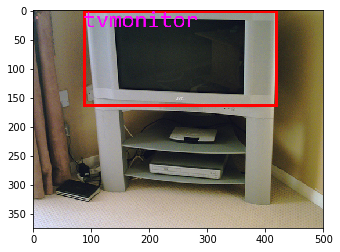

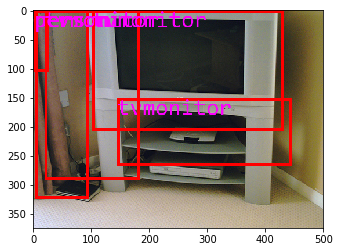

In [51]:
for ii ,(img, bbox, label, scale) in enumerate(checkdataloader):
    oriimg = tonumpy(img[0])
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict([oriimg],
                                                            visualize=True)
#     pdb.set_trace()
    print(ii,end=".")
    print(type(oriimg),oriimg.shape)
    print(oriimg.max(),oriimg.min())
    if _labels[0].shape[0] != 0:
        ori_img=visual_img_bbox(oriimg,bbox,label,label,inverse=False)
        plt.figure(0)
        plt.imshow(ori_img)
        pred_img = visual_img_bbox(oriimg, tonumpy((_bboxes[0])[np.newaxis]),
                               tonumpy((_labels[0].reshape(-1))[np.newaxis]),
                              tonumpy((_labels[0].reshape(-1))[np.newaxis]),
                            inverse=False)
        plt.figure(1)
        plt.imshow(pred_img)
        print(_bboxes[0].shape, _labels[0].shape, _scores[0].shape)
        print(np.array(VOC_BBOX_LABEL_NAMES)[(np.array(_labels[0]).reshape(-1).astype(np.int32))])
        break

## 验证模型性能

In [24]:
testdataset = TestDataset(opt)
testdataloader = torch.utils.data.DataLoader(
    testdataset,
    batch_size=1,
    shuffle=True,
    num_workers=opt.test_data_load_num_workers)
testfasterRCNN = FasterRCNNrensnet34()
testtrainer = FasterRCNNTrainer(testfasterRCNN,opt).cuda()
testtrainer.load(opt.FasterRCNN_model_path)
eval_result=model_eval(testdataloader,testfasterRCNN,test_num=10000)
print(eval_result)

图片数量： 17125
XML数量： 17125


{'ap': array([0.75291207, 0.65552341, 0.68356908, 0.48787361, 0.50886371,
       0.79624276, 0.70438073, 0.83905054, 0.44290035, 0.72060595,
       0.59273467, 0.79432008, 0.61989236, 0.68047229, 0.72102869,
       0.47852008, 0.69233499, 0.54925137, 0.75852162, 0.60452971]), 'map': 0.6541764029307578}
